In [13]:
import json
import os
import re
import logging
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.model_selection import ParameterGrid

from nnattack.variables import auto_var, get_file_name

logging.basicConfig(level=0)

def get_result(auto_var):
    file_name = get_file_name(auto_var, name_only=True).replace("_", "-")
    file_path = f"./results/{file_name}.json"
    if not os.path.exists(file_path):
        return None
    try:
        with open(file_path, "r") as f:
            ret = json.load(f)
    except:
        print("problem with %s" % file_path)
        raise
    return ret


def params_to_dataframe(grid_param, column=None):
    params, loaded_results = auto_var.run_grid_params(get_result, grid_param, with_hook=False, verbose=0, n_jobs=1)
    if column is None:
        results = [r['results'] if isinstance(r, dict) else r for r in loaded_results]
    else:
        results = loaded_results
    
    params, results = zip(*[(params[i], results[i]) for i in range(len(params)) if results[i]])
    params, results = list(params), list(results)
    print(len(results))
    accs = []
    for i, param in enumerate(params):
        if column is None:
            for r in results[i]:
                #params[i][f'eps_{r["eps"]:.2f}_trn'] = r['trn_acc']
                params[i][f'eps_{r["eps"]:.2f}_tst'] = r['tst_acc']
        else:
            if column not in results[i]:
                params[i][column] = np.nan
            else:
                if column == 'avg_pert':
                    params[i][column] = results[i][column]['avg']
                else:
                    params[i][column] = results[i][column]
                          
    df = pd.DataFrame(params)
    return df

def set_plot(fig, ax, ord=np.inf):
    fig.autofmt_xdate()
    ax.legend()
    ax.set_ylim(0, 1)
        #ax.legend(bbox_to_anchor=(1.5, 0., 0.5, 0.5))
    ax.legend()
    ax.set_ylabel('Accuracy')
    xlabel = 'Adversarial Perturbation'
    if ord == np.inf:
        ax.set_xlabel(xlabel + ' (Linf)')
    else:
        ax.set_xlabel(xlabel)
        
                      
def plot_result(df, exp_nme, control_var, variables):
    control = ParameterGrid(control_var)
    for g in control:
        title = exp_name
        temp_df = df
                      
        for k, v in g.items():
            if v in variable_name[k]:
                title = title + f"_{variable_name[k][v]}"
            else:
                title = title + f"_{v}"
            temp_df = temp_df.loc[df[k] == v]
                      
        fig, ax = plt.subplots()
        ax.set_title(title)
        for name, group in temp_df.groupby(variables):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

                      
            if isinstance(name, str):
                if name in variable_name[variables[0]]:
                    label = variable_name[variables[0]][name]
                else:
                    label = name
            else:
                mod_names = []
                for i, n in enumerate(name):
                    if n in variable_name[variables[i]]:
                        mod_names.append(variable_name[variables[i]][n])
                    else:
                        mod_names.append(n)
                label = mod_name.join("_")
            ax.plot(x, s, label=label)

        dataset = g['dataset']
        ord = g['ord']
        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.png', format='png')
        plt.show()
                      
def knn_attack_plots(exp_name, grid_param):
    df = params_to_dataframe(grid_param)
    datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']

    control = {
        'dataset': datasets,
        'ord': grid_param[0]['ord'],
    }
    variables = ['attack']
    plot_result(df, exp_name, control, variables)
                      
def get_avg(df, exp_nme, control_var, variables):
    control = ParameterGrid(control_var)
    for g in control:
        title = exp_name
        temp_df = df
                      
        for k, v in g.items():
            if v in variable_name[k]:
                title = title + f"_{variable_name[k][v]}"
            else:
                title = title + f"_{v}"
            temp_df = temp_df.loc[df[k] == v]
                      
        for name, group in temp_df.groupby(variables):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]
                      
def avg_pert_table(exp_name, grid_param):
    df = params_to_dataframe(grid_param)
    datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']

    control = {
        'dataset': datasets,
        'ord': grid_param[0]['ord'],
    }
    variables = ['attack']
    plot_result(df, exp_name, control, variables)
                      
variable_name = {
    'dataset': {
        'fashion_mnist35_2000_pca5': 'fashion-mnist35-pca5',
        'mnist35_2000_pca5': 'mnist35-pca5',
        'fashion_mnist06_2000_pca5': 'fashion-mnist06-pca5',
        'fashion_mnist35_2000_pca15': 'fashion-mnist35-pca15',
        'mnist35_2000_pca15': 'mnist35-pca15',
        'fashion_mnist06_2000_pca15': 'fashion-mnist06-pca15',
        'digits_pca5': 'digits-pca5',
        'halfmoon_2000': 'halfmoon',
    },
    'attack': {
        'blackbox': 'blackbox (Cheng\'s attack)',
        'kernelsub_c10000_pgd': 'kernelsub',
        'kernelsub_c1000_pgd': 'kernelsub',
        'rev_nnopt_k1_20': 'nnopt-20',
        'rev_nnopt_k1_50': 'nnopt-50',
        'rev_nnopt_k3_20': 'nnopt-20',
        'rev_nnopt_k3_50': 'nnopt-50',
        'rev_nnopt_k5_20': 'nnopt-20',
        'rev_nnopt_k5_50': 'nnopt-50',
        'rev_nnopt_k5_20_region': 'nnopt-20-region',
        'rev_nnopt_k5_50_region': 'nnopt-50-region',
        'direct_k1': 'direct attack'
    },
    'ord': {},
}


In [20]:
#def get_avg(df, exp_nme, control_var, variables):
#    control = ParameterGrid(control_var)
#    for g in control:
#        title = exp_name
#        temp_df = df
#                      
#        for k, v in g.items():
#            if v in variable_name[k]:
#                title = title + f"_{variable_name[k][v]}"
#            else:
#                title = title + f"_{v}"
#            temp_df = temp_df.loc[df[k] == v]
#            
#        retrun temp_df.groupby(variables).mean()['avg_pert']
        

def avg_pert_table(exp_name, grid_param, columns):
    df = params_to_dataframe(grid_param, 'avg_pert')
    datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
    temp_df = df.groupby(["dataset", "attack"])['avg_pert'].mean()
    
    d = {}
    for col in columns:
        d[col] = {}
        for dataset in datasets:
            d[col][dataset] = temp_df[dataset, col]
    return pd.DataFrame(d)
    #return df.groupby(["dataset", "attack"])['avg_pert'].mean()


#from params import nn_k1
#_, exp_name, grid_param, _ = nn_k1()
#t = avg_pert_table(exp_name, grid_param, ['rev_nnopt_k1_20', 'blackbox'])
#print(t.to_latex())

from params import opt_of_rf_attack, rf_attack
_, exp_name, grid_param, _ = opt_of_rf_attack()
t = avg_pert_table(exp_name, grid_param, ['blackbox', 'rf_attack_all', 'rf_attack_rev', 'rf_attack_rev_20', 'rf_attack_rev_50'])
print(t.to_latex())
_, exp_name, grid_param, _ = rf_attack()
t = avg_pert_table(exp_name, grid_param, ['blackbox', 'rf_attack_rev_20', 'rf_attack_rev_100'])
print(t.to_latex())


80
\begin{tabular}{lrrrrr}
\toprule
{} &  blackbox &  rf\_attack\_all &  rf\_attack\_rev &  rf\_attack\_rev\_20 &  rf\_attack\_rev\_50 \\
\midrule
fashion\_mnist06\_200\_pca5 &  0.140183 &       0.076862 &       0.115458 &          0.123644 &          0.115458 \\
fashion\_mnist35\_200\_pca5 &  0.231867 &       0.182789 &       0.247771 &          0.265657 &          0.247771 \\
halfmoon\_200             &  0.163412 &       0.104411 &       0.128362 &          0.128362 &          0.128362 \\
mnist35\_200\_pca5         &  0.148625 &       0.104035 &       0.140596 &          0.143510 &          0.140706 \\
\bottomrule
\end{tabular}

84
\begin{tabular}{lrrr}
\toprule
{} &  blackbox &  rf\_attack\_rev\_20 &  rf\_attack\_rev\_100 \\
\midrule
fashion\_mnist06\_2000\_pca10 &  0.154556 &          0.120954 &           0.120719 \\
fashion\_mnist06\_2000\_pca5  &  0.144811 &          0.081379 &           0.081379 \\
fashion\_mnist35\_2000\_pca10 &  0.191441 &          0.257679 &           0.25364

168
blackbox 4
direct_k1 4
kernelsub_c1000_pgd 4
rev_nnopt_k1_20 4


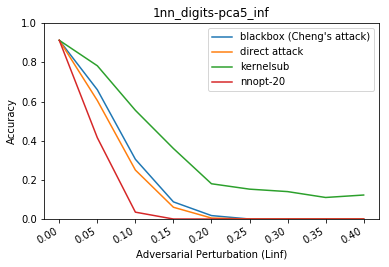

blackbox 4
direct_k1 4
kernelsub_c10000_pgd 4
rev_nnopt_k1_20 4
rev_nnopt_k1_50 4


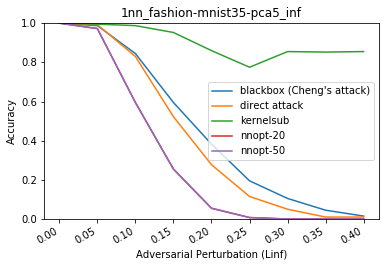

blackbox 4
direct_k1 4
kernelsub_c1000_pgd 4
rev_nnopt_k1_20 4


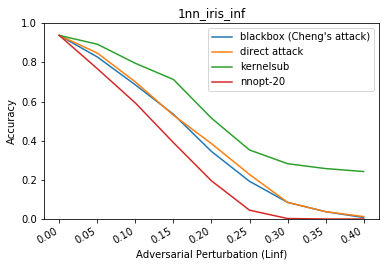

blackbox 4
direct_k1 4
kernelsub_c10000_pgd 4
rev_nnopt_k1_20 4
rev_nnopt_k1_50 4


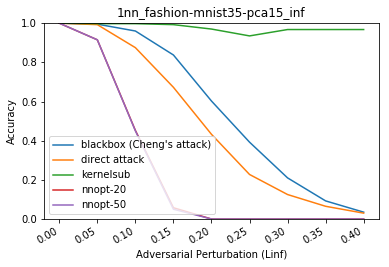

blackbox 4
direct_k1 4
kernelsub_c1000_pgd 4
rev_nnopt_k1_20 4


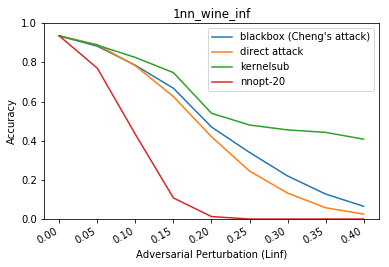

blackbox 4
direct_k1 4
kernelsub_c10000_pgd 4
rev_nnopt_k1_20 4
rev_nnopt_k1_50 4


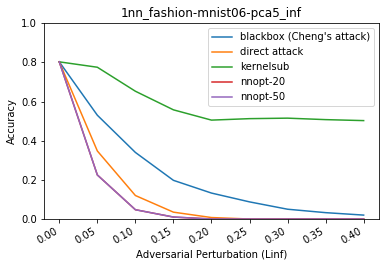

blackbox 4
direct_k1 4
kernelsub_c10000_pgd 4
rev_nnopt_k1_20 4
rev_nnopt_k1_50 4


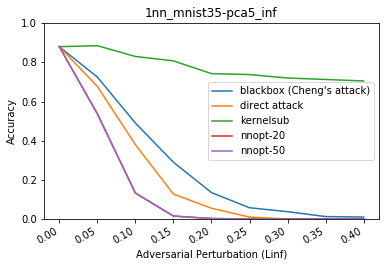

blackbox 4
direct_k1 4
kernelsub_c10000_pgd 4
rev_nnopt_k1_20 4
rev_nnopt_k1_50 4


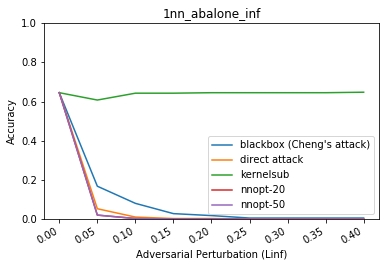

blackbox 4
direct_k1 4
kernelsub_c1000_pgd 4
rev_nnopt_k1_20 4
rev_nnopt_k1_50 4


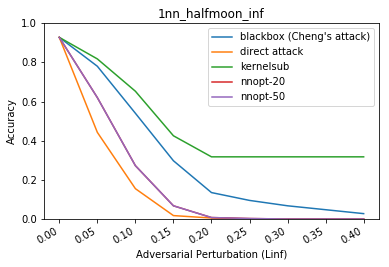

In [3]:
from params import nn_k1
_, exp_name, grid_param, _ = nn_k1()
knn_attack_plots(exp_name, grid_param)

96
blackboxrev_nnopt_k3_50_region 4
direct_k3 4
rev_nnopt_k3_50 4


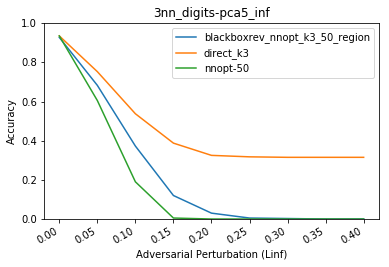

blackboxrev_nnopt_k3_50_region 4
direct_k3 4
rev_nnopt_k3_50 4


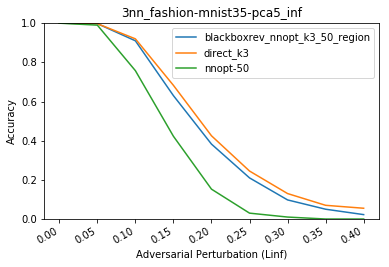

blackboxrev_nnopt_k3_50_region 4
direct_k3 4
rev_nnopt_k3_50 4


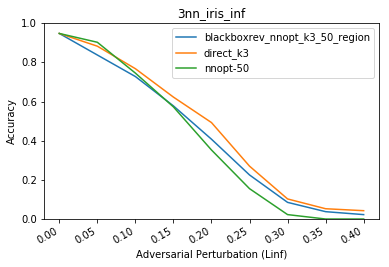

blackboxrev_nnopt_k3_50_region 4
direct_k3 4
rev_nnopt_k3_50 4


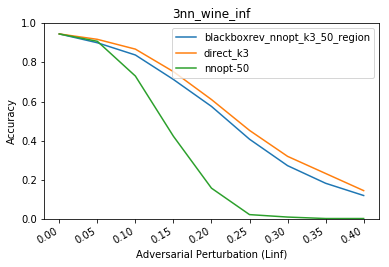

blackboxrev_nnopt_k3_50_region 4
direct_k3 4
rev_nnopt_k3_50 4


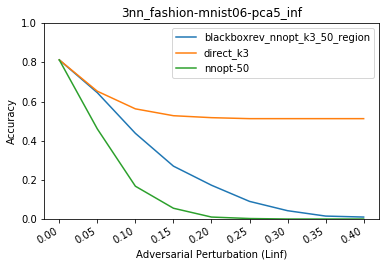

blackboxrev_nnopt_k3_50_region 4
direct_k3 4
rev_nnopt_k3_50 4


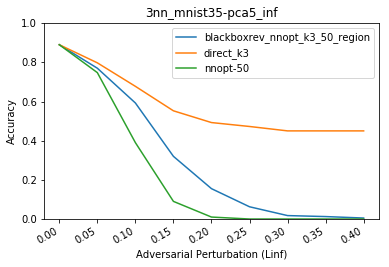

blackboxrev_nnopt_k3_50_region 4
direct_k3 4
rev_nnopt_k3_50 4


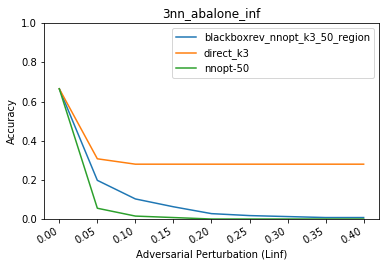

blackboxrev_nnopt_k3_50_region 4
direct_k3 4
rev_nnopt_k3_50 4


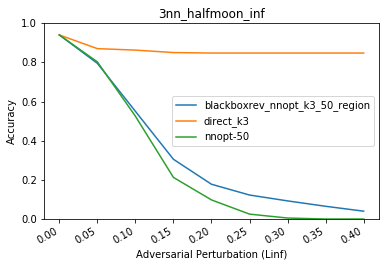

In [4]:
from params import nn_k3
_, exp_name, grid_param, _ = nn_k3()
knn_attack_plots(exp_name, grid_param)


192
blackbox 4
direct_k5 4
rev_nnopt_k5_20 4
rev_nnopt_k5_20_region 4
rev_nnopt_k5_50 4
rev_nnopt_k5_50_region 4


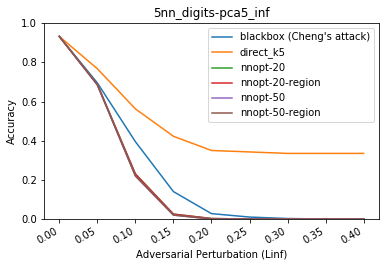

blackbox 4
direct_k5 4
rev_nnopt_k5_20 4
rev_nnopt_k5_20_region 4
rev_nnopt_k5_50 4
rev_nnopt_k5_50_region 4


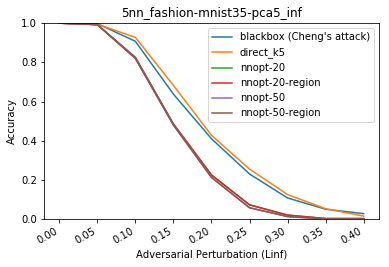

blackbox 4
direct_k5 4
rev_nnopt_k5_20 4
rev_nnopt_k5_20_region 4
rev_nnopt_k5_50 4
rev_nnopt_k5_50_region 4


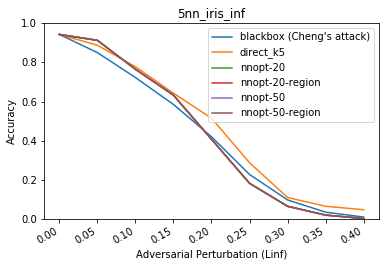

blackbox 4
direct_k5 4
rev_nnopt_k5_20 4
rev_nnopt_k5_20_region 4
rev_nnopt_k5_50 4
rev_nnopt_k5_50_region 4


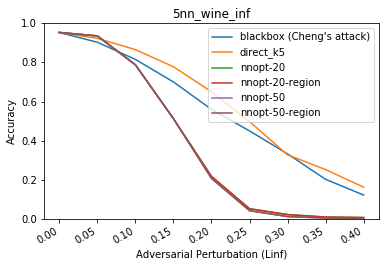

blackbox 4
direct_k5 4
rev_nnopt_k5_20 4
rev_nnopt_k5_20_region 4
rev_nnopt_k5_50 4
rev_nnopt_k5_50_region 4


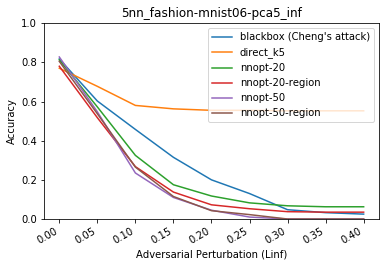

blackbox 4
direct_k5 4
rev_nnopt_k5_20 4
rev_nnopt_k5_20_region 4
rev_nnopt_k5_50 4
rev_nnopt_k5_50_region 4


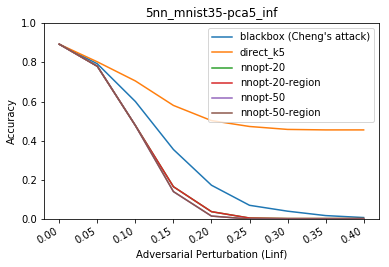

blackbox 4
direct_k5 4
rev_nnopt_k5_20 4
rev_nnopt_k5_20_region 4
rev_nnopt_k5_50 4
rev_nnopt_k5_50_region 4


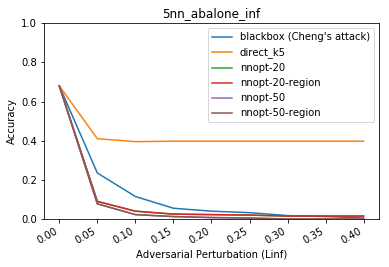

blackbox 4
direct_k5 4
rev_nnopt_k5_20 4
rev_nnopt_k5_20_region 4
rev_nnopt_k5_50 4
rev_nnopt_k5_50_region 4


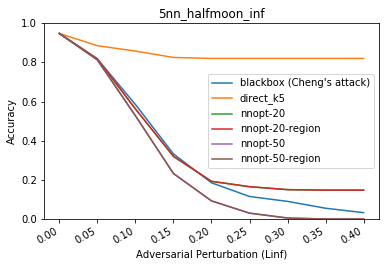

In [5]:
from params import nn_k5
_, exp_name, grid_param, _ = nn_k5()
knn_attack_plots(exp_name, grid_param)

192
blackbox 4
direct_k7 4
rev_nnopt_k7_20 4
rev_nnopt_k7_20_region 4
rev_nnopt_k7_50 4
rev_nnopt_k7_50_region 4


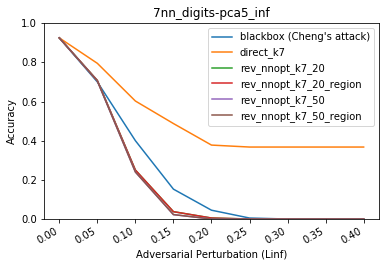

blackbox 4
direct_k7 4
rev_nnopt_k7_20 4
rev_nnopt_k7_20_region 4
rev_nnopt_k7_50 4
rev_nnopt_k7_50_region 4


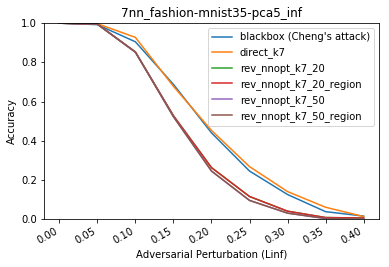

blackbox 4
direct_k7 4
rev_nnopt_k7_20 4
rev_nnopt_k7_20_region 4
rev_nnopt_k7_50 4
rev_nnopt_k7_50_region 4


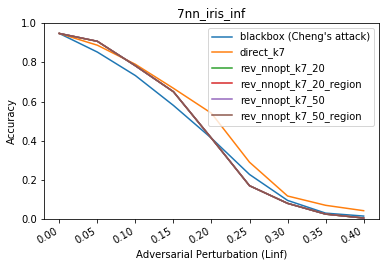

blackbox 4
direct_k7 4
rev_nnopt_k7_20 4
rev_nnopt_k7_20_region 4
rev_nnopt_k7_50 4
rev_nnopt_k7_50_region 4


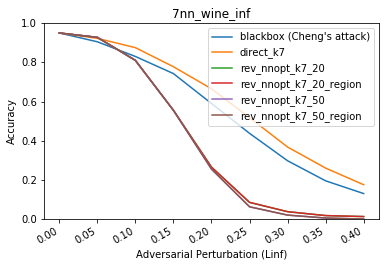

blackbox 4
direct_k7 4
rev_nnopt_k7_20 4
rev_nnopt_k7_20_region 4
rev_nnopt_k7_50 4
rev_nnopt_k7_50_region 4


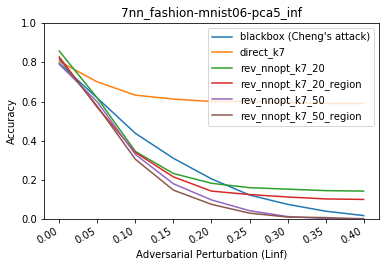

blackbox 4
direct_k7 4
rev_nnopt_k7_20 4
rev_nnopt_k7_20_region 4
rev_nnopt_k7_50 4
rev_nnopt_k7_50_region 4


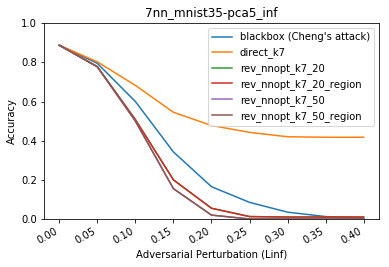

blackbox 4
direct_k7 4
rev_nnopt_k7_20 4
rev_nnopt_k7_20_region 4
rev_nnopt_k7_50 4
rev_nnopt_k7_50_region 4


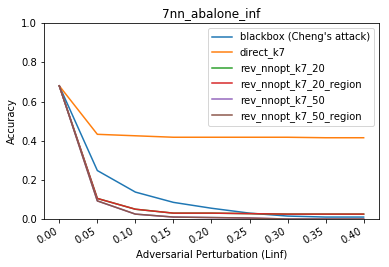

blackbox 4
direct_k7 4
rev_nnopt_k7_20 4
rev_nnopt_k7_20_region 4
rev_nnopt_k7_50 4
rev_nnopt_k7_50_region 4


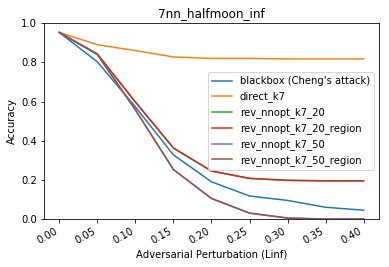

In [6]:
from params import nn_k7
_, exp_name, grid_param, _ = nn_k7()
knn_attack_plots(exp_name, grid_param)

80
{'mnist35_2000_pca5', 'fashion_mnist06_2000_pca5mnist35_2000_pca15', 'abalone', 'fashion_mnist06_2000_pca15', 'halfmoon_2000'}
mnist35_2000_pca5
('mnist35_2000_pca5', 'robust1nn', 'inf', 'blackbox') 4
('mnist35_2000_pca5', 'robust1nn', 'inf', 'direct_k1') 4
('mnist35_2000_pca5', 'robust1nn', 'inf', 'kernelsub_c100_pgd') 4
('mnist35_2000_pca5', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 4


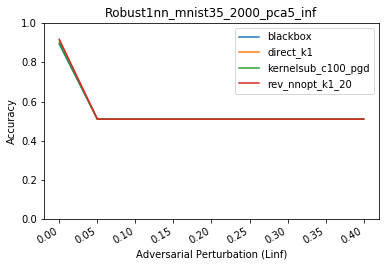

fashion_mnist06_2000_pca5mnist35_2000_pca15
('fashion_mnist06_2000_pca5mnist35_2000_pca15', 'robust1nn', 'inf', 'blackbox') 4
('fashion_mnist06_2000_pca5mnist35_2000_pca15', 'robust1nn', 'inf', 'direct_k1') 4
('fashion_mnist06_2000_pca5mnist35_2000_pca15', 'robust1nn', 'inf', 'kernelsub_c100_pgd') 4
('fashion_mnist06_2000_pca5mnist35_2000_pca15', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 4


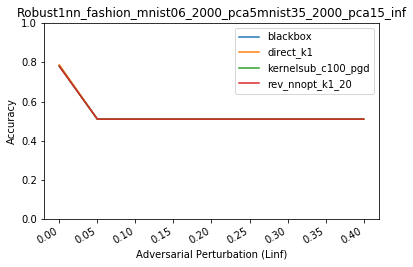

abalone
('abalone', 'robust1nn', 'inf', 'blackbox') 4
('abalone', 'robust1nn', 'inf', 'direct_k1') 4
('abalone', 'robust1nn', 'inf', 'kernelsub_c100_pgd') 4
('abalone', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 4


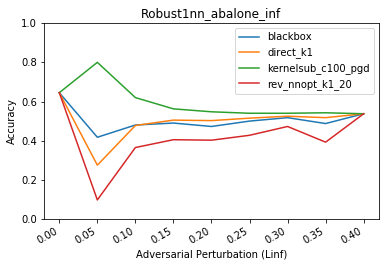

fashion_mnist06_2000_pca15
('fashion_mnist06_2000_pca15', 'robust1nn', 'inf', 'blackbox') 4
('fashion_mnist06_2000_pca15', 'robust1nn', 'inf', 'direct_k1') 4
('fashion_mnist06_2000_pca15', 'robust1nn', 'inf', 'kernelsub_c100_pgd') 4
('fashion_mnist06_2000_pca15', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 4


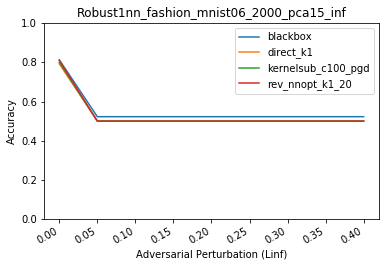

halfmoon_2000
('halfmoon_2000', 'robust1nn', 'inf', 'blackbox') 4
('halfmoon_2000', 'robust1nn', 'inf', 'direct_k1') 4
('halfmoon_2000', 'robust1nn', 'inf', 'kernelsub_c10_pgd') 4
('halfmoon_2000', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 4


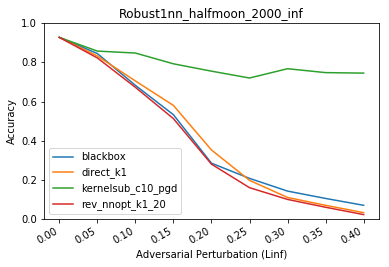

In [7]:
from params import robust_nn_k1
_, exp_name, grid_param, _ = robust_nn_k1()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{exp_name}_{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s" % (name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.png', format='png')
        plt.show()

In [10]:
from params import opt_of_nnopt
_, exp_name, grid_param, _ = opt_of_nnopt()
knn_attack_plots(exp_name, grid_param)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


ValueError: not enough values to unpack (expected 2, got 0)

84
blackbox 4
rf_attack_rev_100 4
rf_attack_rev_20 4


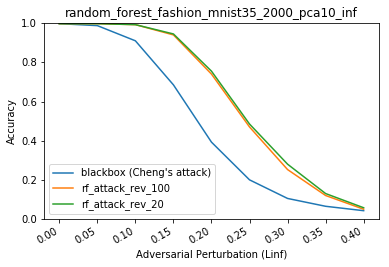

blackbox 4
rf_attack_rev_100 4
rf_attack_rev_20 4


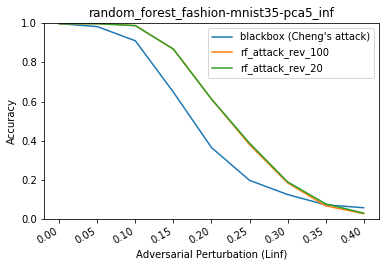

blackbox 4
rf_attack_rev_100 4
rf_attack_rev_20 4


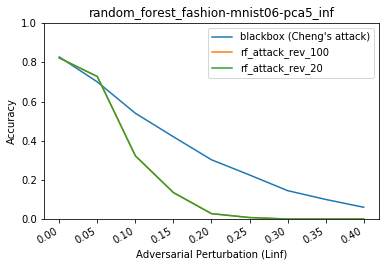

blackbox 4
rf_attack_rev_100 4
rf_attack_rev_20 4


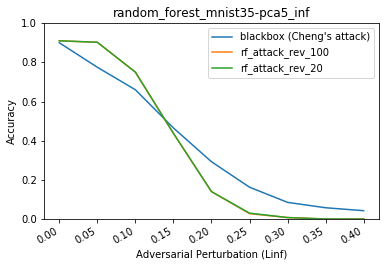

blackbox 4
rf_attack_rev_100 4
rf_attack_rev_20 4


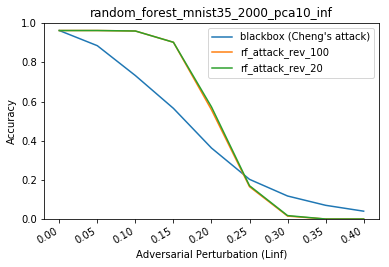

blackbox 4
rf_attack_rev_100 4
rf_attack_rev_20 4


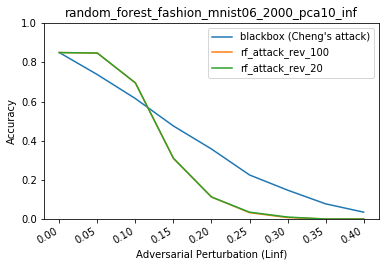

blackbox 4
rf_attack_rev_100 4
rf_attack_rev_20 4


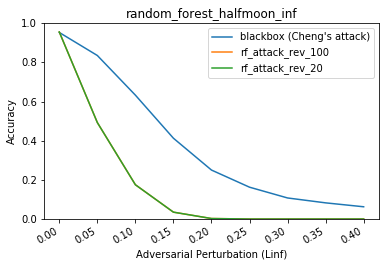

In [18]:
from params import rf_attack
_, exp_name, grid_param, _ = rf_attack()
knn_attack_plots(exp_name, grid_param)

In [ ]:
from params import rf500_attack
_, exp_name, grid_param, _ = rf500_attack()
knn_attack_plots(exp_name, grid_param)

80
blackbox 4
rf_attack_all 4
rf_attack_rev 4
rf_attack_rev_20 4
rf_attack_rev_50 4


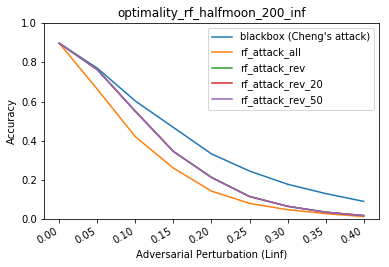

blackbox 4
rf_attack_all 4
rf_attack_rev 4
rf_attack_rev_20 4
rf_attack_rev_50 4


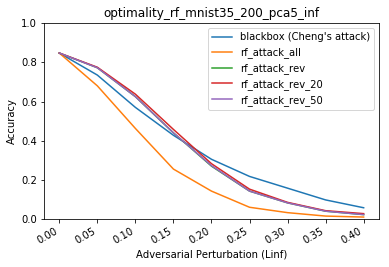

blackbox 4
rf_attack_all 4
rf_attack_rev 4
rf_attack_rev_20 4
rf_attack_rev_50 4


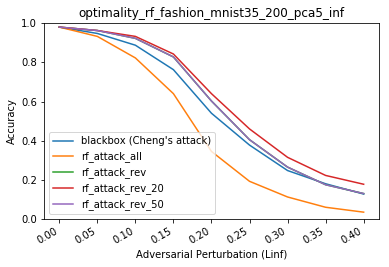

blackbox 4
rf_attack_all 4
rf_attack_rev 4
rf_attack_rev_20 4
rf_attack_rev_50 4


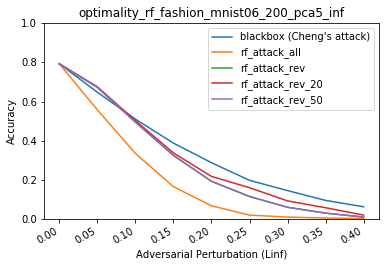

In [17]:
from params import opt_of_rf_attack
_, exp_name, grid_param, _ = opt_of_rf_attack()
knn_attack_plots(exp_name, grid_param)